In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import json
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt

/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/laylabouzoubaa/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# new file from joe on 11/5/24
dat = pd.read_csv('../data/nonfiltered_cooccurrence.csv')

In [5]:
# make graph and do clustering
G = nx.Graph()
# Add edges with weights
for i, row in dat.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Cooccurrence_Count'])

In [6]:
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 99751
Number of edges: 472081


In [7]:
# Filter out non-influential nodes
# You can adjust the threshold based on your needs
degree_centrality = nx.degree_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

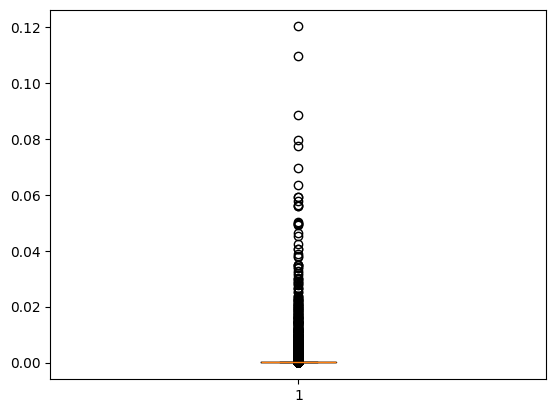

Mean Degree Centrality: 9.488910595402604e-05
Median Degree Centrality: 2.0050125313283208e-05
Standard Deviation of Degree Centrality: 0.0012398693337224685
Max Degree Centrality: 0.12025062656641604
Min Degree Centrality: 1.0025062656641604e-05
Inter-quartile range: 2.0050125313283208e-05
75th percentile: 4.0100250626566415e-05
25th percentile: 2.0050125313283208e-05


In [8]:
# Analyze the distribution of betweenness centrality
centrality_values = list(degree_centrality.values())
# box plot
plt.boxplot(centrality_values)
plt.show()

# Calculate descriptive statistics
mean_centrality = np.mean(centrality_values)
median_centrality = np.median(centrality_values)
std_centrality = np.std(centrality_values)

print(f'Mean Degree Centrality: {mean_centrality}')
print(f'Median Degree Centrality: {median_centrality}')
print(f'Standard Deviation of Degree Centrality: {std_centrality}')
print(f'Max Degree Centrality: {max(centrality_values)}')
print(f'Min Degree Centrality: {min(centrality_values)}')
print(f"Inter-quartile range: {np.percentile(centrality_values, 75) - np.percentile(centrality_values, 25)}")
print(f"75th percentile: {np.percentile(centrality_values, 75)}"
        f"\n25th percentile: {np.percentile(centrality_values, 25)}")

---
### Graph filtering

1. filter edges by weight
2. remove isolated nodes
3. apply minimum degree threshold

In [10]:
# Check edge weights distribution
weights = [d['weight'] for (u,v,d) in G.edges(data=True)]
print("Total number of edges:", len(weights))
print("Min weight:", min(weights))
print("Max weight:", max(weights))
print("Sample of first 5 weights:", weights[:5])

# Get a frequency count of weights
from collections import Counter
weight_counts = Counter(weights)
print("\nWeight distribution:")
for weight, count in sorted(weight_counts.items())[:10]:  # Show first 10 weights
    print(f"Weight {weight}: {count} edges")

Total number of edges: 472081
Min weight: 1
Max weight: 1825
Sample of first 5 weights: [112, 5, 1320, 1359, 52]

Weight distribution:
Weight 1: 359881 edges
Weight 2: 49953 edges
Weight 3: 17982 edges
Weight 4: 10464 edges
Weight 5: 6323 edges
Weight 6: 3799 edges
Weight 7: 2952 edges
Weight 8: 2305 edges
Weight 9: 1584 edges
Weight 10: 1482 edges


In [11]:
# 1. Filter edges by weight
min_weight = np.percentile([d['weight'] for (u,v,d) in G.edges(data=True)], 25)  # bottom 25%
G_filtered = G.copy()
# More explicit filtering approach
edges_to_remove = []
for u, v, d in G.edges(data=True):
    if 'weight' in d:  # Check if weight attribute exists
        if d['weight'] <= 1.0:  # or whatever threshold you want
            edges_to_remove.append((u,v))
    else:
        print(f"Edge {u}-{v} has no weight attribute!")

print(f"Found {len(edges_to_remove)} edges to remove")
G_filtered.remove_edges_from(edges_to_remove)

Found 359881 edges to remove


In [12]:
# Remove any isolated nodes after edge removal
isolated_nodes = list(nx.isolates(G_filtered))
G_filtered.remove_nodes_from(isolated_nodes)

In [13]:
print("\nFiltered graph:")
print(f"Nodes: {G_filtered.number_of_nodes()}")
print(f"Edges: {G_filtered.number_of_edges()}")
print(f"Removed {len(isolated_nodes)} isolated nodes")



Filtered graph:
Nodes: 27514
Edges: 112200
Removed 72237 isolated nodes


In [14]:
avg_degree = sum(dict(G_filtered.degree()).values()) / G_filtered.number_of_nodes()
print(f"\nAverage degree: {avg_degree:.2f}")

# Look at the largest connected component
largest_cc = max(nx.connected_components(G_filtered), key=len)
print(f"Largest connected component has {len(largest_cc)} nodes")


Average degree: 8.16
Largest connected component has 27514 nodes


---
### Level 2 filtering to get CORE nodes

3 options: 90th percentile by degree, k-core, and pagerank

In [15]:
# 1. Using edge weights and degree together
# Calculate weighted degree for each node
weighted_degrees = dict()
for node in G_filtered.nodes():
    weighted_degree = sum(d['weight'] for u, v, d in G_filtered.edges(data=True) if u == node or v == node)
    weighted_degrees[node] = weighted_degree

# Get 90th percentile of weighted degrees
threshold = np.percentile(list(weighted_degrees.values()), 90)
core_nodes = [node for node, w_degree in weighted_degrees.items() if w_degree >= threshold]

# Create subgraph of core nodes
G_core = G_filtered.subgraph(core_nodes).copy()

print("\nCore graph (top 10% by weighted degree):")
print(f"Nodes: {G_core.number_of_nodes()}")
print(f"Edges: {G_core.number_of_edges()}")


Core graph (top 10% by weighted degree):
Nodes: 2781
Edges: 43026


In [20]:
print("Core graph analysis (top 10% by weighted degree):")
# Connectivity
print(f"Number of connected components: {nx.number_connected_components(G_core)}")

# Edge weight distribution
weights = [d['weight'] for (u,v,d) in G_core.edges(data=True)]
print(f"Min edge weight: {min(weights)}")
print(f"Max edge weight: {max(weights)}")
print(f"Mean edge weight: {np.mean(weights):.2f}")

# Node degree distribution
degrees = [d for n, d in G_core.degree()]
print(f"Mean degree: {np.mean(degrees):.2f}")
print(f"Median degree: {np.median(degrees):.2f}")

# Calculate PageRank scores for the weighted degree core graph
pr_core = nx.pagerank(G_core, weight='weight')
top_hashtags = sorted(pr_core.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 hashtags by PageRank in weighted degree core:")
for hashtag, score in top_hashtags:
    print(f"{hashtag}: {score:.6f}")

# Additional weighted degree specific metrics
print(f"\nWeighted degree specific metrics:")
# Get weighted degree distribution
weighted_degrees = {node: sum(d['weight'] for u, v, d in G_core.edges(data=True) if u == node or v == node) 
                   for node in G_core.nodes()}
print(f"Min weighted degree: {min(weighted_degrees.values())}")
print(f"Max weighted degree: {max(weighted_degrees.values())}")
print(f"Mean weighted degree: {np.mean(list(weighted_degrees.values())):.2f}")

Core graph analysis (top 10% by weighted degree):
Number of connected components: 1
Min edge weight: 2
Max edge weight: 1825
Mean edge weight: 24.45
Mean degree: 30.94
Median degree: 12.00

Top 10 hashtags by PageRank in weighted degree core:
addiction: 0.023860
high: 0.017275
recovery: 0.016667
sober: 0.016438
sobriety: 0.015468
harmreduction: 0.015086
addy: 0.013292
wedorecover: 0.013260
x: 0.011250
g: 0.011243

Weighted degree specific metrics:
Min weighted degree: 12
Max weighted degree: 82796
Mean weighted degree: 756.47


#### K-core decomposition

In [16]:
# 2. Alternative: k-core decomposition
# This will find the most densely connected subset of nodes
k_core = nx.k_core(G_filtered, k=10)  # adjust k as needed
print("\nk-core graph (k=10):")
print(f"Nodes: {k_core.number_of_nodes()}")
print(f"Edges: {k_core.number_of_edges()}")


k-core graph (k=10):
Nodes: 2340
Edges: 47071


In [19]:
print("K-core graph analysis:")
# Connectivity
print(f"Number of connected components: {nx.number_connected_components(k_core)}")

# Edge weight distribution
weights = [d['weight'] for (u,v,d) in k_core.edges(data=True)]
print(f"Min edge weight: {min(weights)}")
print(f"Max edge weight: {max(weights)}")
print(f"Mean edge weight: {np.mean(weights):.2f}")

# Node degree distribution
degrees = [d for n, d in k_core.degree()]
print(f"Mean degree: {np.mean(degrees):.2f}")
print(f"Median degree: {np.median(degrees):.2f}")

# Calculate PageRank scores for the k-core graph to identify important nodes
pr_kcore = nx.pagerank(k_core, weight='weight')
top_hashtags = sorted(pr_kcore.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 hashtags by PageRank in k-core:")
for hashtag, score in top_hashtags:
    print(f"{hashtag}: {score:.6f}")

# Additional k-core specific metrics
print(f"\nK-core specific metrics:")
# Core number distribution
core_numbers = nx.core_number(k_core)
print(f"Min core number: {min(core_numbers.values())}")
print(f"Max core number: {max(core_numbers.values())}")
print(f"Mean core number: {np.mean(list(core_numbers.values())):.2f}")

K-core graph analysis:
Number of connected components: 1
Min edge weight: 2
Max edge weight: 1825
Mean edge weight: 12.33
Mean degree: 40.23
Median degree: 17.00

Top 10 hashtags by PageRank in k-core:
addiction: 0.026389
recovery: 0.021507
harmreduction: 0.020697
wedorecover: 0.017982
sober: 0.015859
sobriety: 0.013596
addy: 0.011419
nan: 0.010767
soberlife: 0.009576
harmreductionworks: 0.008701

K-core specific metrics:
Min core number: 10
Max core number: 46
Mean core number: 20.92


#### PageRank Importance

In [17]:
pr = nx.pagerank(G_filtered, weight='weight')
# Keep top 2000 nodes (or adjust number as needed)
top_nodes = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:2000]
G_pagerank = G_filtered.subgraph([node for node, score in top_nodes]).copy()

print("\nPageRank-filtered graph (top 2000 nodes):")
print(f"Nodes: {G_pagerank.number_of_nodes()}")
print(f"Edges: {G_pagerank.number_of_edges()}")


PageRank-filtered graph (top 2000 nodes):
Nodes: 2000
Edges: 36995


In [18]:
print("PageRank graph analysis:")
# Connectivity
print(f"Number of connected components: {nx.number_connected_components(G_pagerank)}")

# Edge weight distribution
weights = [d['weight'] for (u,v,d) in G_pagerank.edges(data=True)]
print(f"Min edge weight: {min(weights)}")
print(f"Max edge weight: {max(weights)}")
print(f"Mean edge weight: {np.mean(weights):.2f}")

# Node degree distribution
degrees = [d for n, d in G_pagerank.degree()]
print(f"Mean degree: {np.mean(degrees):.2f}")
print(f"Median degree: {np.median(degrees):.2f}")

# Optional: Look at some top hashtags
pr_subset = {node: score for node, score in pr.items() if node in G_pagerank.nodes()}
top_hashtags = sorted(pr_subset.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 hashtags by PageRank:")
for hashtag, score in top_hashtags:
    print(f"{hashtag}: {score:.6f}")

PageRank graph analysis:
Number of connected components: 1
Min edge weight: 2
Max edge weight: 1825
Mean edge weight: 26.84
Mean degree: 36.99
Median degree: 16.00

Top 10 hashtags by PageRank:
addiction: 0.017710
recovery: 0.014172
harmreduction: 0.011970
wedorecover: 0.010917
sober: 0.009830
sobriety: 0.008844
cat: 0.008692
o: 0.008666
addy: 0.008647
g: 0.008272


#### Decision: K-Core filtering
1. Structural advantages:  

Highest mean degree (40.23)  
Guaranteed minimum connectivity (k=10)  
More edges but lower mean weight suggests better coverage of relationships  


2. Best thematic coherence:  

Top hashtags form the most coherent theme  
Less noise in top hashtags compared to other methods  
No single-letter or ambiguous hashtags in top 10  


3. Size and density balance:  

Middle ground in node count (2340)  
Highest edge count suggests better preserved relationships  
Core number distribution provides natural community structure  


4. Quality guarantees:  

K-core gives us mathematical guarantees about connectivity  
Other methods might include peripheral nodes just because they have a few high-weight edges 

In [8]:
# remove nodes with only one edge
nodes_to_remove = [node for node in G.nodes if G.degree(node) == 1]
G.remove_nodes_from(nodes_to_remove)

# remove isolates
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

In [10]:

# threshold = mean_centrality - std_centrality
# threshold degree centrality above the 25th percentile
threshold = np.percentile(centrality_values2, 25)
filtered_nodes_D = [node for node, centrality in degree_centrality.items() if centrality > threshold]
filtered_nodes_D2 = [node for node in filtered_nodes_D if pd.notnull(node)]
# filtered_nodes_B = [node for node, centrality in betweenness_centrality.items() if centrality > threshold]

In [21]:
# Create a subgraph with the filtered nodes
H = G.subgraph(filtered_nodes_D2)
# weight detials
# print(H.edges(data=True))

In [22]:
# print graph details
print(nx.info(H))

Graph with 14569 nodes and 206289 edges


/var/folders/jj/bt0ykz9n5_16z2gvbybl0tbc0000gn/T/ipykernel_90851/1694325736.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(H))


In [23]:
# do another isolate removal
isolates2 = list(nx.isolates(H))
# H.remove_nodes_from(isolates)


In [ ]:
# Perform clustering with Clauset-Newman-Moore algorithm
# communities = list(greedy_modularity_communities(H))

# # Assign community labels to nodes
# community_dict = {}
# for i, community in enumerate(communities):
#     for node in community:
#         community_dict[node] = i

# # Add community information to the nodes in the graph
# nx.set_node_attributes(H, community_dict, 'community')

# # Print out the communities
# for i, community in enumerate(communities):
#     print(f"Community {i + 1}: {sorted(community)}")


## Add in themes from `get_themes.py` as community

In [24]:
# add themes as nodes
communities = pd.read_csv("../data/themes_with_missing_long.csv")

In [25]:
# Create a dictionary mapping hashtags to themes
community_map = dict(zip(communities['hashtag'], communities['theme']))

In [26]:
# Assign communities to nodes
for node in H.nodes():
    if node in community_map:
        H.nodes[node]['community'] = community_map[node]
    else:
        # Handle nodes that are not in the DataFrame
        H.nodes[node]['community'] = "Unknown"

In [33]:
# export for gephi
nx.write_gexf(H, '../graphs/double_hits_filtered_upper75_with_theme.gexf')

In [13]:
# add themes as nodes
# communities = pd.read_csv("../data/themes_with_missing_long.csv")
communities = pd.read_csv("../data/double_hits_filtered_upper75_with_theme_node_list_manually_classified.csv")

In [14]:
# replace the value of community if the value of Joe's theme is not missing.
communities.loc[(communities['Community'] == 'Unknown') & (communities["Joe\'s Community Tag"].notnull()), 'Community'] = communities["Joe\'s Community Tag"]

In [16]:
# Create a dictionary mapping hashtags to themes
community_map = dict(zip(communities['Node'], communities['Community']))

In [17]:
# Assign communities to nodes
for node in H.nodes():
    if node in community_map:
        H.nodes[node]['community'] = community_map[node]
    else:
        # Handle nodes that are not in the DataFrame
        H.nodes[node]['community'] = "Unknown"

In [18]:
# export for gephi
nx.write_gexf(H, '../graphs/double_hits_filtered_upper75_with_theme_no_unknown.gexf')

In [19]:
edge_data = []
for source, target, data in H.edges(data=True):
    weight = data.get('weight', 1)  # Default to 1 if weight is not specified
    source_community = H.nodes[source].get('community', 'Unknown')
    target_community = H.nodes[target].get('community', 'Unknown')
    edge_data.append({
        'Source': source,
        'Target': target,
        'Weight': weight,
        'Source_Community': source_community,
        'Target_Community': target_community
    })

# Create a DataFrame
edge_data_df = pd.DataFrame(edge_data)
edge_data_df.to_csv('../graphs/double_hits_filtered_upper75_with_theme_edge_list_full.csv', index=False)

In [20]:
# get nodelist
node_data = []
for node in H.nodes():
    community = H.nodes[node].get('community', 'Unknown')
    weighted_degree = sum(weight for _, _, weight in H.edges(node, data='weight', default=1))
    
    node_data.append({
        'Node': node,
        'Community': community,
        'Weighted_Degree': weighted_degree
    })

# Create a DataFrame
node_data_df = pd.DataFrame(node_data)

# Write to CSV
node_data_df.to_csv('../graphs/double_hits_filtered_upper75_with_theme_node_list_full.csv', index=False, quoting=1)  # quoting=1 ensures all fields are quoted


In [21]:
# experiment with no misc/unknown
subgraph = H.subgraph([
    node for node in H.nodes() 
    if H.nodes[node].get('community') not in ["misc", "Unknown"]
]).copy()

In [22]:
nx.write_gexf(subgraph, "../graphs/double_hits_filtered_upper75_with_theme_nomisc.gexf")

In [14]:
# export to csv
# nodes
# nodes = pd.DataFrame(H.nodes(data=True), columns=['node', 'data'])
# nodes['community'] = nodes['data'].apply(lambda x: x['community'])
# nodes.drop(columns=['data'], inplace=True)
# nodes.to_csv('../data/double_hits_filtered_upper75_nodes.csv', index=False)

In [19]:
# read seed hashtags and clusters
# seed_hashtags = pd.read_csv("community-grouping_20240730(in).csv")

In [22]:
def label_hashtags_by_clusters(G, seed_hashtags):
    # Create a dictionary to store the cluster for each hashtag
    hashtag_clusters = {}

    # Iterate through each theme and its associated hashtags
    for theme in seed_hashtags.columns[1:]:
        seed_nodes = seed_hashtags['Node'][seed_hashtags[theme] == 'y'].tolist()
        for seed in seed_nodes:
            # Get the ego network up to 2 hops
            ego_network = nx.ego_graph(G, seed, radius=1, undirected=True)
            for node in ego_network.nodes:
                if node not in hashtag_clusters:
                    hashtag_clusters[node] = set()
                hashtag_clusters[node].add(theme)
    
    # Convert the dictionary to a DataFrame
    labeled_hashtags = pd.DataFrame(list(hashtag_clusters.items()), columns=['Hashtag', 'Themes'])
    labeled_hashtags['Themes'] = labeled_hashtags['Themes'].apply(lambda x: list(x))
    
    return labeled_hashtags

In [23]:
labeled_hashtags = label_hashtags_by_clusters(H, seed_hashtags)

# OLD
---
TRIPLE HITS

In [18]:
# redo with triple hits
dat = pd.read_csv('triple_hits_edges_no_dupes.csv')

In [19]:
G2 = nx.Graph()
# Add edges with weights
for i, row in dat.iterrows():
    G2.add_edge(row['source'], row['target'], weight=row['weight'])

degree_centrality2 = nx.degree_centrality(G2)

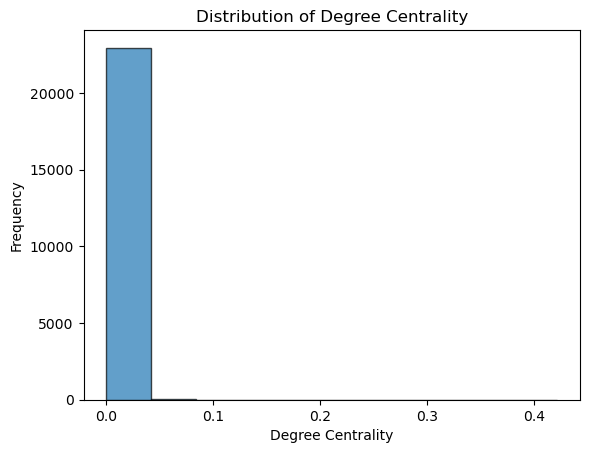

In [20]:
# plot degree centrality
centrality_values2 = list(degree_centrality2.values())
plt.hist(centrality_values2, edgecolor='k', alpha=0.7)
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality')
plt.show()


In [21]:
# descriptive statistics
mean_centrality2 = np.mean(centrality_values2)
median_centrality2 = np.median(centrality_values2)
std_centrality2 = np.std(centrality_values2)

print(f'Mean Degree Centrality: {mean_centrality2}')
print(f'Median Degree Centrality: {median_centrality2}')
print(f'Standard Deviation of Degree Centrality: {std_centrality2}')

# Set a threshold based on the distribution
# For example, use the mean or a multiple of the standard deviation
threshold2 = mean_centrality2 + std_centrality2  # Example threshold

Mean Degree Centrality: 0.0005783704455376405
Median Degree Centrality: 0.0001738299074355743
Standard Deviation of Degree Centrality: 0.0064888479505552325


In [22]:
filtered_nodes_D2 = [node for node, centrality in degree_centrality2.items() if centrality > threshold2]

H2 = G2.subgraph(filtered_nodes_D2)


In [23]:
# Perform clustering with Clauset-Newman-Moore algorithm
communities2 = list(greedy_modularity_communities(H2))

# Assign community labels to nodes
community_dict2 = {}
for i, community in enumerate(communities2):
    for node in community:
        community_dict2[node] = i

# Add community information to the nodes in the graph
nx.set_node_attributes(H2, community_dict2, 'community')

# Print out the communities
for i, community in enumerate(communities2):
    print(f"Community {i + 1}: {sorted(community)}")

Community 1: ['addictionhumor', 'addictionskit', 'bars', 'blackedout', 'blackout', 'coughsyrup', 'dr00g', 'dr00gtiktok', 'drank', 'drunk', 'drvgaddiction', 'drvgzx', 'hammered', 'hangover', 'harmreduction', 'hungover', 'lean', 'leantok', 'm0lly', 'molly', 'opiates', 'percs', 'pinger', 'pingertok', 'pingerzzzz', 'pingtok', 'recovery', 'relapsehappens', 'shitfaced', 'sober', 'soberlife', 'sobriety', 'syrup', 'tipsy', 'wasted', 'wedorecover', 'xan', 'xans', 'xantok']
Community 2: ['chronicpain', 'cleanandsober', 'detox', 'drugpolicy', 'drugrehab', 'endoverdose', 'fent', 'harmreductionsaveslives', 'harmreductiontips', 'harmreductionworks', 'heroin', 'methadoneclinic', 'na', 'naloxone', 'naloxonesaveslives', 'naltrexone', 'narcan', 'narcansaveslives', 'odaat', 'onedayatatime', 'opioidaddiction', 'opioidawareness', 'opioidcrisis', 'opioids', 'overdose', 'overdoseawareness', 'overdosecrisis', 'overdoseresponse', 'pain', 'pwud', 'safesupply', 'saynotodrugs', 'soberhouse', 'soberliving', 'sobri

In [24]:
nx.write_gexf(H2, 'triple_hits_filtered.gexf')

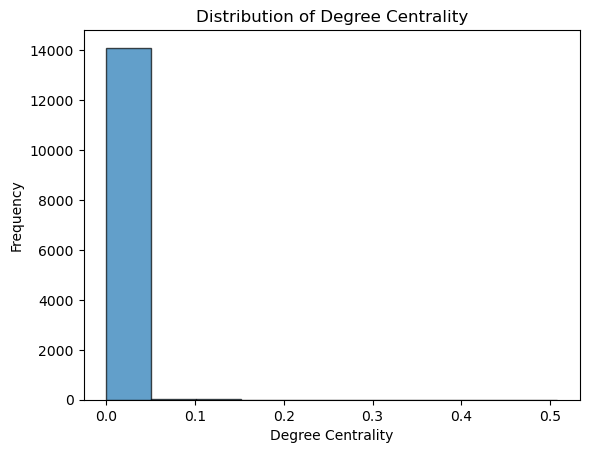

Mean Degree Centrality: 0.0011391684336007726
Median Degree Centrality: 0.0003532819896841659
Standard Deviation of Degree Centrality: 0.010455500072650259


In [25]:
# repeat for quadruple hits
dat = pd.read_csv('quadruple_hits_edges_no_dupes.csv')

G3 = nx.Graph()
# Add edges with weights
for i, row in dat.iterrows():
    G3.add_edge(row['source'], row['target'], weight=row['weight'])

degree_centrality3 = nx.degree_centrality(G3)

# plot degree centrality
centrality_values3 = list(degree_centrality3.values())
plt.hist(centrality_values3, edgecolor='k', alpha=0.7)
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality')
plt.show()


# descriptive statistics
mean_centrality3 = np.mean(centrality_values3)
median_centrality3 = np.median(centrality_values3)
std_centrality3 = np.std(centrality_values3)

print(f'Mean Degree Centrality: {mean_centrality3}')
print(f'Median Degree Centrality: {median_centrality3}')
print(f'Standard Deviation of Degree Centrality: {std_centrality3}')

# Set a threshold based on the distribution
threshold3 = mean_centrality3 + std_centrality3  


In [26]:
# filter
filtered_nodes_D3 = [node for node, centrality in degree_centrality3.items() if centrality > threshold3]

H3 = G3.subgraph(filtered_nodes_D3)


# Perform clustering with Clauset-Newman-Moore algorithm
communities3 = list(greedy_modularity_communities(H3))

# Assign community labels to nodes
community_dict3 = {}
for i, community in enumerate(communities3):
    for node in community:
        community_dict3[node] = i

# Add community information to the nodes in the graph
nx.set_node_attributes(H3, community_dict3, 'community')

# Print out the communities
for i, community in enumerate(communities3):
    print(f"Community {i + 1}: {sorted(community)}")

nx.write_gexf(H3, 'quadruple_hits_filtered.gexf')

Community 1: ['acid', 'addiction', 'addictionhumor', 'addictionskit', 'bars', 'blackedout', 'blackout', 'cigs', 'coughsyrup', 'dr00g', 'dr00gtiktok', 'drank', 'drunk', 'drvgaddiction', 'hammered', 'harmreductionsaveslives', 'high', 'hungover', 'lean', 'molly', 'na', 'percs', 'pinger', 'pingertok', 'pingerzzzz', 'pingtok', 'psychedelictok', 'recovery', 'shitfaced', 'sober', 'soberlife', 'sobriety', 'sobrietybirthday', 'stonertokfyp', 'tipsy', 'wasted', 'wedorecover', 'xan']
Community 2: ['chronicpain', 'cleanandsober', 'drugpolicy', 'drugrehab', 'endoverdose', 'fent', 'harmreductiontips', 'harmreductionworks', 'heroin', 'methadoneclinic', 'naloxone', 'naloxonesaveslives', 'naltrexone', 'narcan', 'narcansaveslives', 'odaat', 'onedayatatime', 'opiates', 'opioidaddiction', 'opioidawareness', 'opioidcrisis', 'opioids', 'overdose', 'overdoseawareness', 'overdosecrisis', 'pwud', 'relapsehappens', 'safesupply', 'soberhouse', 'soberliving', 'substanceabuse', 'substanceusedisorder']
Community 3: